# Sujet de l'étude

<ol>
<li>
Peut-on établir un lien entre la densité de médecins par spécialité  et par territoire et la pratique du dépassement d'honoraires ?
</li>
<li>
Est-ce dans les territoires où la densité est la plus forte que les médecins pratiquent le moins les dépassement d'honoraires ?
</li>
<li>
Est-ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour certaines classes d'ages (bébé / pédiatre, personnes agées / infirmiers etc...)?
</li>
</ol>
Pour ces trois questions, nous entendrons par densité le nombre de praticiens rapporté à la population d'un territoire. Et par territoire, nous entendrons un département.<p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Chargement des données mises en oeuvre par notre étude

In [2]:
# Chargement et mise en forme des honoraires des médecins par département
def income_df(filename, sheetname, category_name):
    df = pd.read_excel(
        filename, sheetname=sheetname, na_values="nc")
    df = df[[category_name, "DEPARTEMENT",
             "HONORAIRES SANS DEPASSEMENT (Euros)", "DEPASSEMENTS (Euros)"]]
    df.dropna(how='any', inplace=True)

    # On se concentre sur les données non agrégées des départements de France métropolitaine
    # Suppresion des aggrégation
    df = df[df[category_name].str.match('(TOTAL.*)') == False]
    # Suppression des DOM-TOM
    df = df[df["DEPARTEMENT"].str.match('([0-9][0-9,AB]-)') == True]
    df.rename(index=str, columns={category_name: "Category"}, inplace=True)
    return df


income_file = "Honoraires_totaux_des_professionnels_de_sante_par_departement_en_2014.xls"
income_gen = income_df(income_file, "Généralistes et MEP",
                       "Généralistes et compétences MEP")
income_spe = income_df(income_file, "Spécialistes", "Spécialistes")
income = income_gen.append(income_spe, ignore_index=True)
income["Ratio dépassement"] = income["DEPASSEMENTS (Euros)"] / \
    income["HONORAIRES SANS DEPASSEMENT (Euros)"]

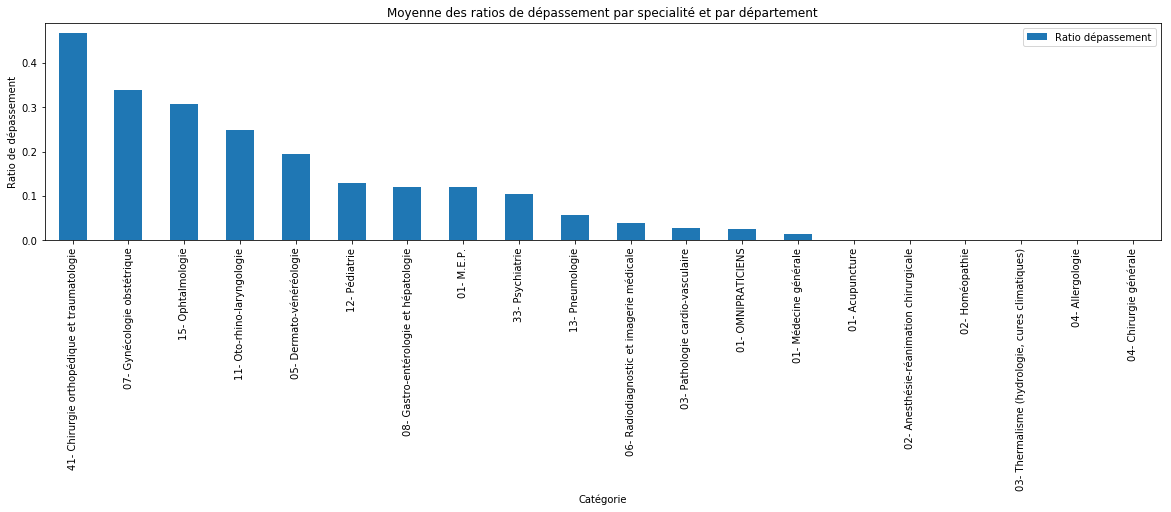

In [3]:
groups_inc = income[["Category", "Ratio dépassement"]].groupby("Category")
groups_inc.agg(np.average).sort_values("Ratio dépassement", ascending=False).head(20).plot(
    kind="bar", figsize=(20, 4), title="Moyenne des ratios de dépassement par specialité et par département")
plt.xlabel("Catégorie")
plt.ylabel("Ratio de dépassement");

In [4]:
# Chargement et mise en forme des densités de médecins par département
def density_df(filename, sheetname, category_name):
    df = pd.read_excel(filename, sheetname=sheetname)
    df = df[[category_name, "DEPARTEMENT", "EFFECTIF",
             "POPULATION FRANCAISE", "DENSITE /100 000 hab."]]
    df.dropna(how='any', inplace=True)
    df = df[df[category_name].str.match('(TOTAL.*)') == False]
    df = df[df["DEPARTEMENT"].str.match('([0-9][0-9,AB]-)') == True]
    df.rename(index=str, columns={category_name: "Category"}, inplace=True)
    return df

density_file = "Effectif_et_densite_par_departement_en_2014.xls"
density_spe = density_df(density_file, "Spécialistes", "Spécialistes")
density_gen = density_df(density_file, "Généralistes et MEP", "Généralistes et compétences MEP")
density = density_gen.append(density_spe, ignore_index=True)

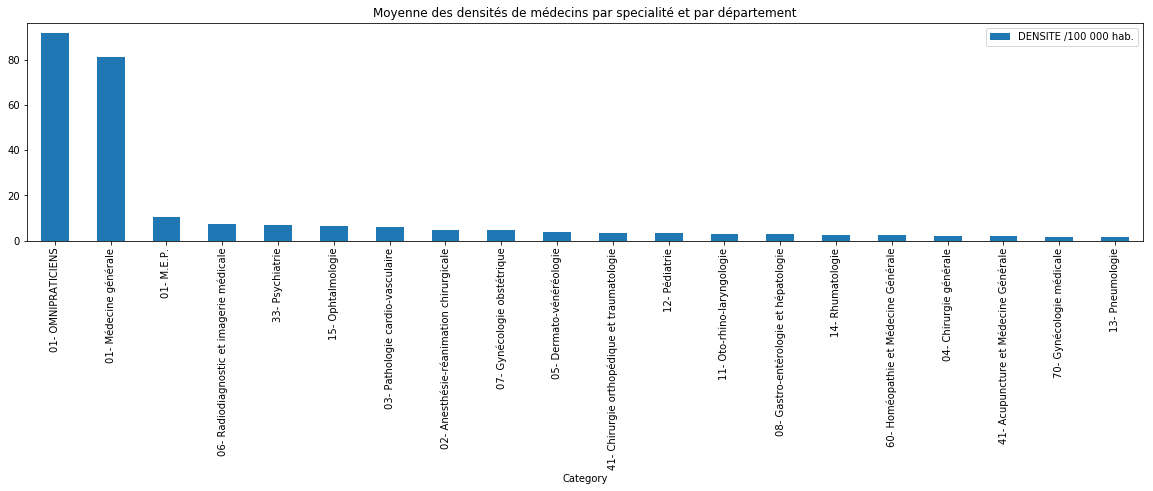

In [5]:
groups_dens = density[["Category", "DENSITE /100 000 hab."]].groupby("Category")
groups_dens.agg(np.average).sort_values("DENSITE /100 000 hab.", ascending=False).head(20).plot(
    kind="bar", figsize=(20, 4), title="Moyenne des densités de médecins par specialité et par département");

In [31]:
# On ne va garder que les spécialités de médecins, c'est à dire qu'un généraliste et un MEP seront confondus.
# Cette nouvelle catégorie est notée CATEGORY_CODE

merged = pd.merge(density, income)
merged["CATEGORY_CODE"] = merged["Category"].str.extract('([0-9][0-9])')
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7683 entries, 0 to 7682
Data columns (total 9 columns):
Category                               7683 non-null object
DEPARTEMENT                            7683 non-null object
EFFECTIF                               7683 non-null int64
POPULATION FRANCAISE                   7683 non-null float64
DENSITE /100 000 hab.                  7683 non-null float64
HONORAIRES SANS DEPASSEMENT (Euros)    7683 non-null float64
DEPASSEMENTS (Euros)                   7683 non-null float64
Ratio dépassement                      1631 non-null float64
CATEGORY_CODE                          7683 non-null object
dtypes: float64(5), int64(1), object(3)
memory usage: 600.2+ KB


/home/alex/anaconda3/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


## Peut-on établir un lien entre la densité de médecins par spécialité et par territoire et la pratique du dépassement d'honoraires
On va calculer la matrice de covariance pour les densités de médecins par département et par spécialité et leurs dépassements d'honoraire par spécialité et par département. On peut commencer par regarder leur position relative par rapport à la moyenne et voir s'il y a correlation.

In [49]:
# moyenne des depassements d'honoraires
moyennes_depassements = merged.groupby(["CATEGORY_CODE", "DEPARTEMENT"]).mean()

# moyenne des densités de population
moyennes_densités = merged.groupby(["CATEGORY_CODE", "DEPARTEMENT"]).mean()

moyennes = moyennes_depassements.merge(moyennes_densités)
moyennes.info()#[["CATEGORY_CODE"]]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 253235 entries, 0 to 253234
Data columns (total 6 columns):
EFFECTIF                               253235 non-null float64
POPULATION FRANCAISE                   253235 non-null float64
DENSITE /100 000 hab.                  253235 non-null float64
HONORAIRES SANS DEPASSEMENT (Euros)    253235 non-null float64
DEPASSEMENTS (Euros)                   253235 non-null float64
Ratio dépassement                      1386 non-null float64
dtypes: float64(6)
memory usage: 13.5 MB
